Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [ ]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
#drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [7]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/My Drive/Upgrad_Files/CNN_assignment/skin_cancer/Train")
data_dir_test = pathlib.Path("/content/gdrive/My Drive/Upgrad_Files/CNN_assignment/skin_cancer/Test")

In [2]:

dataset_name = "melanoma-cnn"

data_dir_train = pathlib.Path(f"/kaggle/input/{dataset_name}/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path(f"/kaggle/input/{dataset_name}/Skin cancer ISIC The International Skin Imaging Collaboration/Test")


In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [4]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [5]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [6]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

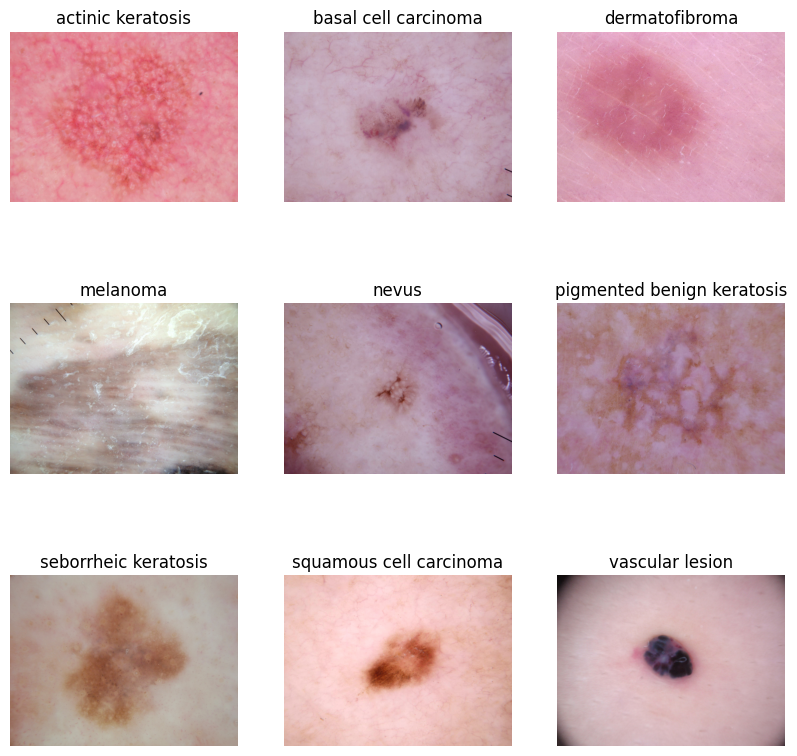

In [8]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  image = plt.imread(
      str(list(data_dir_train.glob(f'{class_names[i]}/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)
  plt.axis('off')

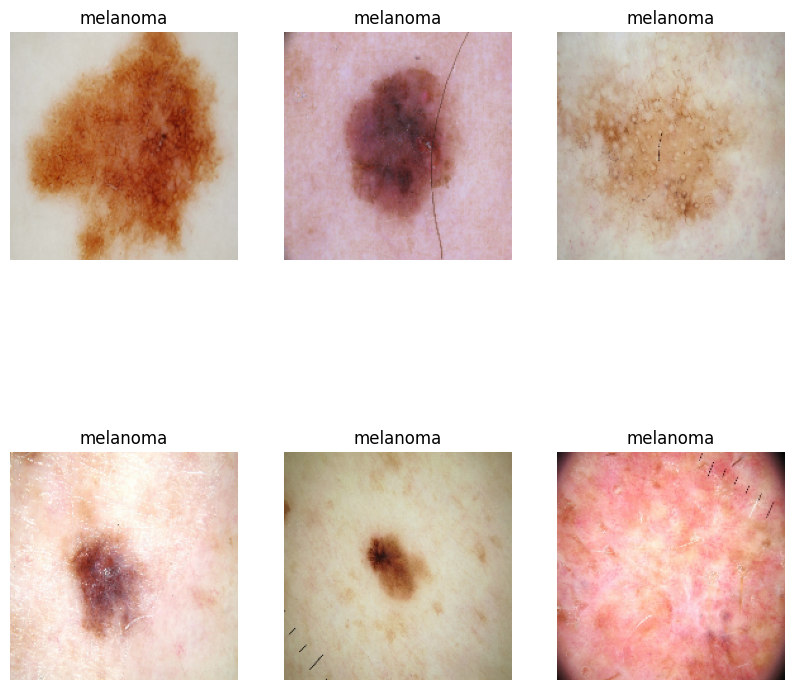

In [9]:
plt.figure(figsize=(10, 10))
count = 0
max_melanoma_images = 6  # Maximum number of melanoma images to display
batches_to_search = 20 #Number of batches to search.

for images, labels in train_ds.take(batches_to_search):
    for i in range(len(images)):
        if class_names[labels[i]] == 'melanoma':
            ax = plt.subplot(2, 3, count + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
            count += 1
            if count >= max_melanoma_images:
                break  # Exit inner loop if 6 melanoma images are found
    if count >= max_melanoma_images:
        break  # Exit outer loop if 6 melanoma images are found

plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Your code goes here
# Number of target labels are 9
target_labels = 9

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(target_labels, activation='softmax')  # <-- Softmax for multi-class classification
])




/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use categorical_crossentropy if one-hot labels
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,294,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,300,777 (31.66 MB)

 Trainable params: 8,300,777 (31.66 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 73ms/step - accuracy: 0.1903 - loss: 8.7962 - val_accuracy: 0.2215 - val_loss: 2.0344
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2561 - loss: 2.0087 - val_accuracy: 0.3154 - val_loss: 1.8024
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4111 - loss: 1.6757 - val_accuracy: 0.5347 - val_loss: 1.5566
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5348 - loss: 1.4420 - val_accuracy: 0.4989 - val_loss: 1.4867
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5278 - loss: 1.3458 - val_accuracy: 0.5526 - val_loss: 1.4158
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5484 - loss: 1.2846 - val_accuracy: 0.5391 - val_loss: 1.4548
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6081 - loss: 1.1735 - val_accuracy: 0.5414 - val_loss: 1.4327
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6724 - loss: 0.9520 - val_accuracy: 0.5347 - v

### Visualizing training results

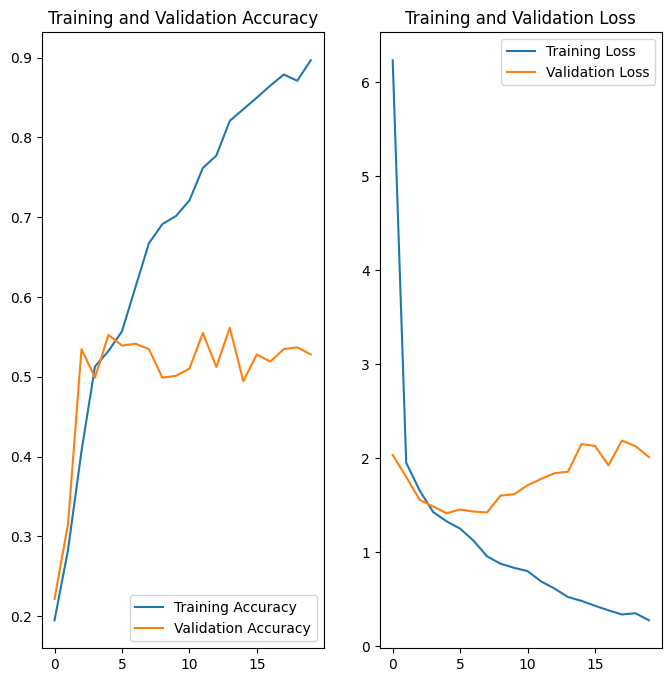

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

Observations

1.   Overfitting: The training accuracy is consistently increasing and reaches a high value, while the validation accuracy plateaus and even fluctuates, indicating overfitting.  Similarly, the training loss is decreasing steadily, but the validation loss starts to increase after a certain point, further confirming overfitting.

2.   Potential for Improvement: The validation accuracy, while plateauing, shows potential for improvement. It suggests that the model is learning some useful features, but needs regularization to generalize better.

3.   Loss Divergence: The divergence between the training and validation loss, especially noticeable after epoch 5, is a strong indicator of overfitting. This means the model is memorizing the training data rather than learning generalizable patterns.





Based on the provided accuracy and loss graphs:

Overfitting:

The training accuracy continues to improve, reaching above 90%, whereas the validation accuracy plateaus around 50-55% and fluctuates.
Training loss is continuously decreasing, but validation loss stagnates and even starts increasing slightly, indicating overfitting.
Potential Causes:

Lack of Data Augmentation: The model may be memorizing training data instead of generalizing.
Insufficient Regularization: No dropout or batch normalization layers are used.
Network Depth: A deeper network could help learn better hierarchical features.
Imbalanced Dataset: If the dataset has class imbalances, the model may favor certain classes.
Improved CNN with Data Augmentation
For the second iteration, let's introduce:

Data Augmentation: Helps in generalization.
Dropout: Prevents overfitting.
Batch Normalization: Stabilizes learning.
Increased Filters: Improves feature extraction.

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
augmentation_data = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

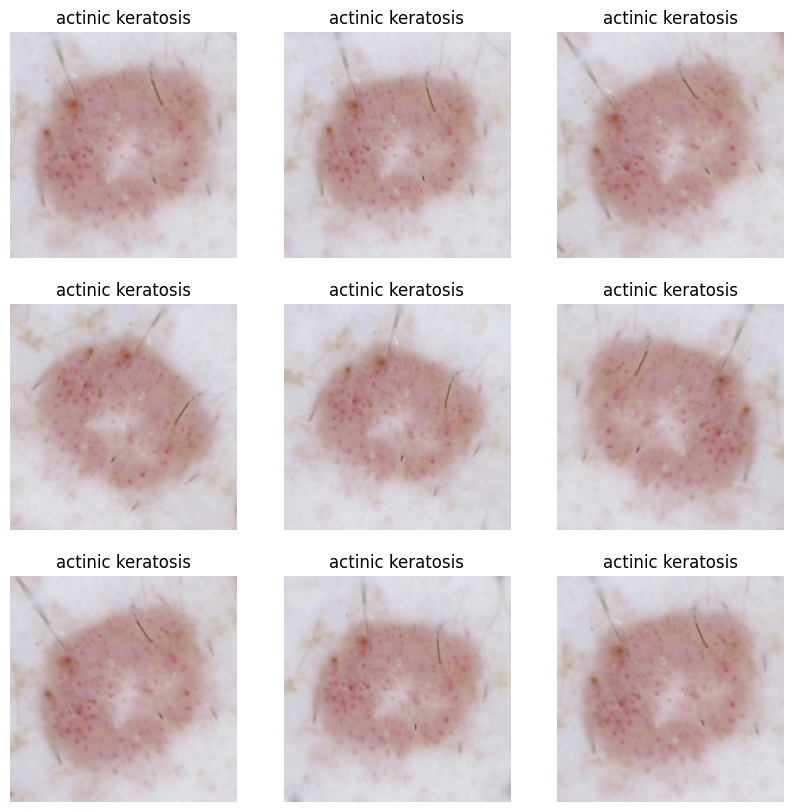

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = augmentation_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential([
  augmentation_data,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(target_labels, activation='softmax')  # Multi-class classification
])


### Compiling the model

In [19]:
## Your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [20]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 102ms/step - accuracy: 0.2038 - loss: 8.4221 - val_accuracy: 0.2371 - val_loss: 11.6790
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.2741 - loss: 11.6555 - val_accuracy: 0.1499 - val_loss: 13.7022
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.2707 - loss: 11.6921 - val_accuracy: 0.1365 - val_loss: 13.8876
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.2191 - loss: 12.5320 - val_accuracy: 0.1566 - val_loss: 13.5940
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.2662 - loss: 11.8057 - val_accuracy: 0.1790 - val_loss: 13.2334
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.2849 - loss: 11.5000 - val_accuracy: 0.2707 - val_loss: 11.7358
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.3317 - loss: 10.7671 - val_accuracy: 0.3043 - val_loss: 11.2071
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.3086 - loss: 11.1402 - val_accu

### Visualizing the results

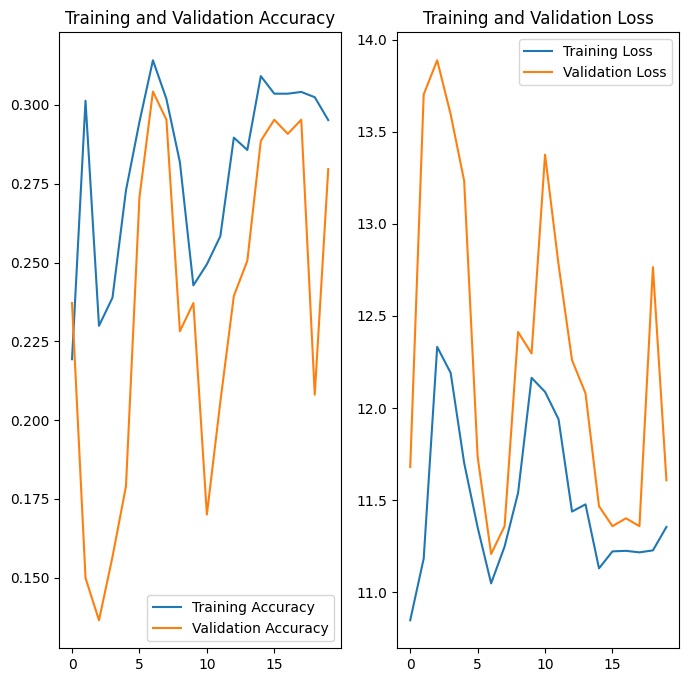

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?


Observations :
1.  Improved Validation Accuracy but Plateauing:

The validation accuracy shows improvement compared to the previous graph, reaching a higher peak. However, it plateaus and fluctuates after epoch 10. This indicates that the model is learning, but it might be hitting a performance ceiling.

2.   Reduced Overfitting (But Still Present):

The gap between training and validation accuracy is smaller than in the previous scenario, suggesting a reduction in overfitting.
The validation loss is also tracking the training loss more closely, but there are still fluctuations and a slight uptick towards the end, which hints at some remaining overfitting.

3. Potential for Further Optimization:

The fluctuations in the validation accuracy and loss suggest that the model's learning process is not entirely stable.
There's room for improvement in both accuracy and loss.




1. Evidence of Underfitting
The new results suggest severe underfitting rather than overfitting. Here's why:

Low accuracy: Both training and validation accuracy remain very low (30%), indicating the model struggles to learn patterns from the data.
High and fluctuating loss: Training and validation loss are both very high (11-14), and fluctuate significantly rather than smoothly decreasing.
Unstable accuracy and loss curves: The training and validation curves exhibit extreme variance, suggesting the model is not converging properly.

2. Comparison to Previous Model
Previous model (before augmentation & regularization): Showed signs of overfitting (training accuracy was very high while validation accuracy stagnated).
Current model: Shows underfitting, meaning it cannot capture meaningful patterns from the data.
Degradation in performance: The accuracy dropped significantly compared to the first model. This suggests that while regularization was necessary to prevent overfitting, it may have been applied too aggressively.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [22]:

def plot_class_distribution_with_labels_and_percentages(dataset, class_names):
    """
    Plots the distribution of classes in a TensorFlow dataset with labels and percentages on top of each bar.

    Args:
        dataset: A TensorFlow dataset object.
        class_names: A list of class names.
    """
    class_counts = {name: 0 for name in class_names}
    total_samples = 0

    for _, labels in dataset:
        if isinstance(labels, tf.Tensor):  # Handle batched labels
            labels = labels.numpy()
            for label in labels:
                class_counts[class_names[label]] += 1
                total_samples += 1
        else: #Handle single labels.
          class_counts[class_names[labels]] += 1
          total_samples += 1

    class_labels = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    bars = plt.bar(class_labels, counts)
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.title("Class Distribution with Percentages")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    # Add labels and percentages on top of each bar
    for bar, count in zip(bars, counts):
        percentage = (count / total_samples) * 100
        label = f"{count}\n({percentage:.1f}%)"  # Combine count and percentage
        plt.text(bar.get_x() + bar.get_width() / 2, count, label, ha='center', va='bottom')

    plt.show()



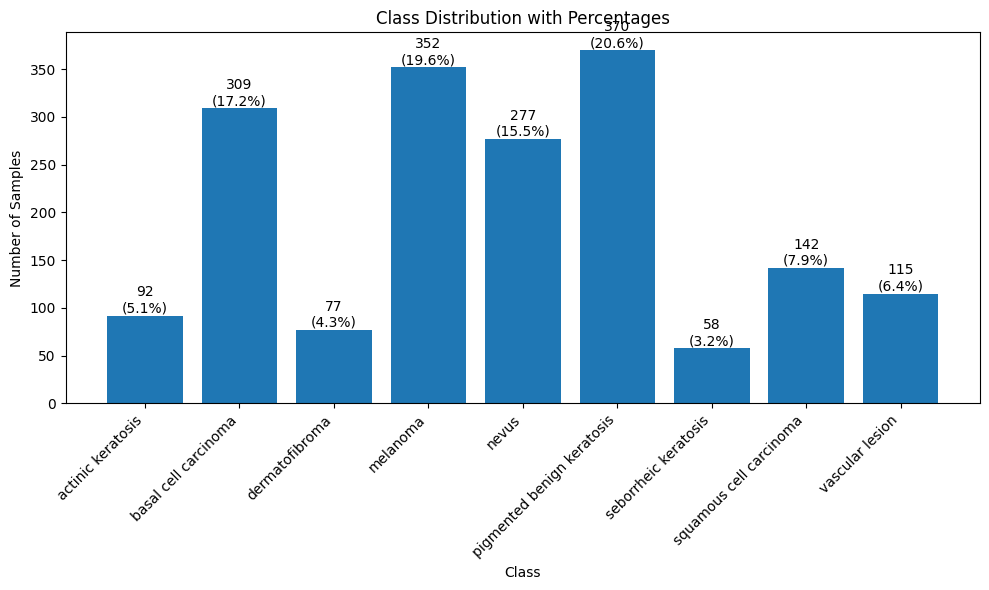

In [23]:
plot_class_distribution_with_labels_and_percentages(train_ds, class_names)

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
seborrheic keratosis has the least number of samples - 58
#### - Which classes dominate the data in terms proportionate number of samples?
pigmented benign keratosis has the most number of samples - 20.6% , followed by melanoma with 19.6%


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [24]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [25]:
path_to_training_dataset = str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Insufficient rights to read or write output directory (/kaggle/input/melanoma-cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output)
Initialised with 114 image(s) found.
Output directory set to /kaggle/input/melanoma-cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]


AttributeError: 'FileNotFoundError' object has no attribute 'message'

In [26]:
# Define a writable output directory
output_dir = "/kaggle/working/train_augmented"
os.makedirs(output_dir, exist_ok=True)

# Loop through all classes and generate augmented data
for class_name in class_names:
    input_path = os.path.join(str(data_dir_train), class_name)  # Path to original images
    output_path = os.path.join(output_dir, class_name)  # Path for augmented images
    
    os.makedirs(output_path, exist_ok=True)  # Ensure the output directory exists

    p = Augmentor.Pipeline(source_directory=input_path, output_directory=output_path)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  # Generate 500 new images per class

Initialised with 114 image(s) found.
Output directory set to /kaggle/working/train_augmented/actinic keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D9529C8BA90>: 100%|██████████| 500/500 [00:06<00:00, 72.20 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to /kaggle/working/train_augmented/basal cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D954FC13A30>: 100%|██████████| 500/500 [00:06<00:00, 72.00 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to /kaggle/working/train_augmented/dermatofibroma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D949C50A0B0>: 100%|██████████| 500/500 [00:07<00:00, 69.43 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to /kaggle/working/train_augmented/melanoma.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D949C6C7CD0>: 100%|██████████| 500/500 [00:39<00:00, 12.74 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to /kaggle/working/train_augmented/nevus.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D954FC13EB0>: 100%|██████████| 500/500 [00:38<00:00, 12.92 Samples/s]                   


Initialised with 462 image(s) found.
Output directory set to /kaggle/working/train_augmented/pigmented benign keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D9529C22110>: 100%|██████████| 500/500 [00:07<00:00, 69.72 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to /kaggle/working/train_augmented/seborrheic keratosis.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7D954F32B1F0>: 100%|██████████| 500/500 [00:17<00:00, 29.01 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /kaggle/working/train_augmented/squamous cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D954F325960>: 100%|██████████| 500/500 [00:07<00:00, 70.76 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to /kaggle/working/train_augmented/vascular lesion.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D954FC20850>: 100%|██████████| 500/500 [00:07<00:00, 68.46 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

AttributeError: 'str' object has no attribute 'glob'

### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here

#### **Todo:**  Train your model

In [ ]:
epochs = 30
## Your code goes here, use 50 epochs.
history = # your model fit code

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

